# Analiza obrazów

Dyskretna transformata Fouriera umożliwa przekształcenie obrazu z domeny czasu do domeny częstotliwościowej. Ze względu na charakterystykę DFT przekształcane obrazy powinny na brzegach mieć nmożliwie iskie wartości, aby uniknąć powstawania artefaktów - zwykle oznacza to konieczność odwrócenia kolorów.

In [1]:
from PIL import Image, ImageOps
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from tqdm import tqdm
from numpy.fft import fft2, ifft2

In [2]:
%matplotlib notebook

Poniższe funkcje słuzą do przygotowania danych wejściowych i wizualizacji obrazu wraz z wynikiem jego transformacji.

In [3]:
def load_text(name):
    "loads image and returns it in greyscale with inverted colors"
    img = Image.open(name).convert('L')
    return np.array(ImageOps.invert(img))

def fourier_components(img):
    "splits imaginary array into real components (length, angle)"
    fourier = fft2(img)
    mod = np.absolute(fourier)
    angle = np.angle(fourier)
    return mod, angle

def visualise_dft(img, font_size=20):
    mod, angle = fourier_components(img)
    #mod /= np.max(mod)
    big_num_idx = mod.flatten().argsort()[int((mod.shape[0]*mod.shape[1])*0.99)]
    new_maximum = mod.flatten()[big_num_idx]
    mod[mod>new_maximum] = new_maximum
    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(7,10))
    for ax in axes: ax.axis("off")
    axes[0].imshow(img)
    axes[0].set_title("original image", fontdict={"fontsize": font_size})
    pos = axes[1].imshow(mod)
    fig.colorbar(pos, ax=axes[1])
    axes[1].set_title("modulus of coefficients", fontdict={"fontsize": font_size})
    pos = axes[2].imshow(angle)
    fig.colorbar(pos, ax=axes[2])
    axes[2].set_title("phase of coefficients", fontdict={"fontsize": font_size})
    plt.show()

Poniżej znajduje się wizualizacja współczynników Fouriera (wartości modułu i fazy) dla obrazu z tekstem. Jako, że kilka wartości modułu jest znacząco odstających to na potrzeby wizualizacji są one pomniejszone (wszystkie wartości stanowiące górny 1% są zmienione na najniższą wartość z tego jednego procenta).

<IPython.core.display.Javascript object>


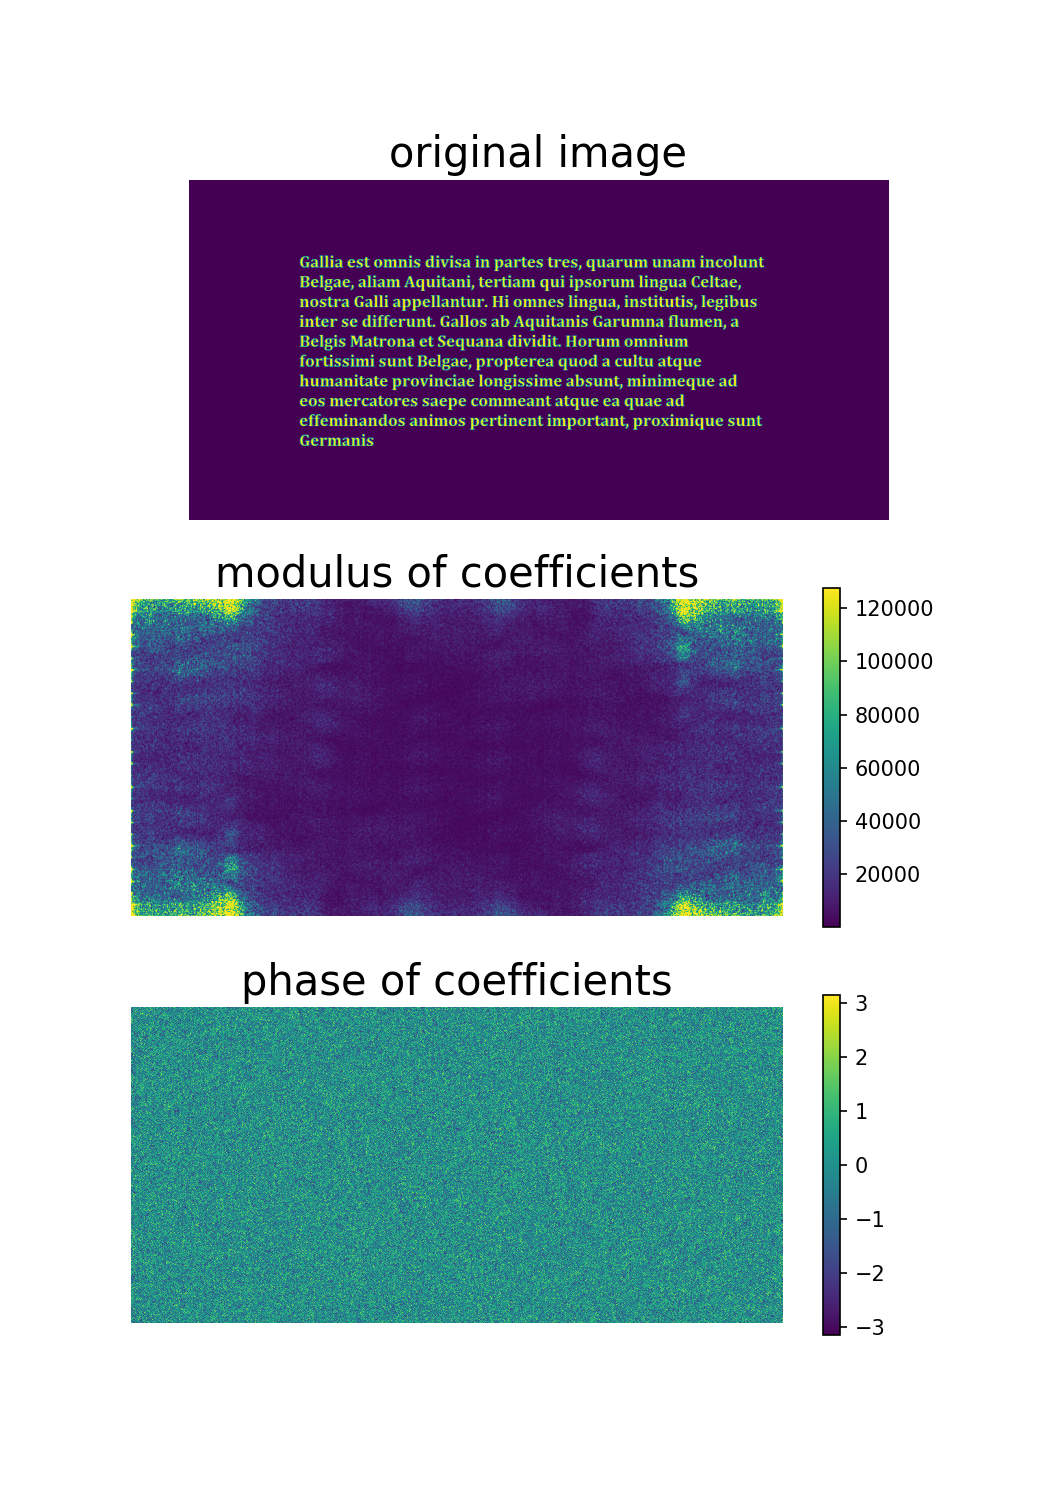

In [4]:
galia = load_text("galia.png").astype(np.float64)
template_e = load_text("galia_e.png").astype(np.float64)
h, w = galia.shape
visualise_dft(galia)

In [6]:
mod, angle = fourier_components(galia)
mod /= np.max(mod)
big_num_idx = mod.flatten().argsort()[int((mod.shape[0]*mod.shape[1])*0.99)]
mod.flatten()[big_num_idx]

0.016869487572068215

## Wizualizacja na sztucznym obrazie

Poniższa wizualizacja także pokazuje wartości modułu i fazy, lecz na prostszym, syntetycznym obrazie. Ma ona na celu zapewnienie prostszego do analizy przykładu pozbawionego szumu.

In [7]:
from matplotlib.widgets import Slider

<IPython.core.display.Javascript object>


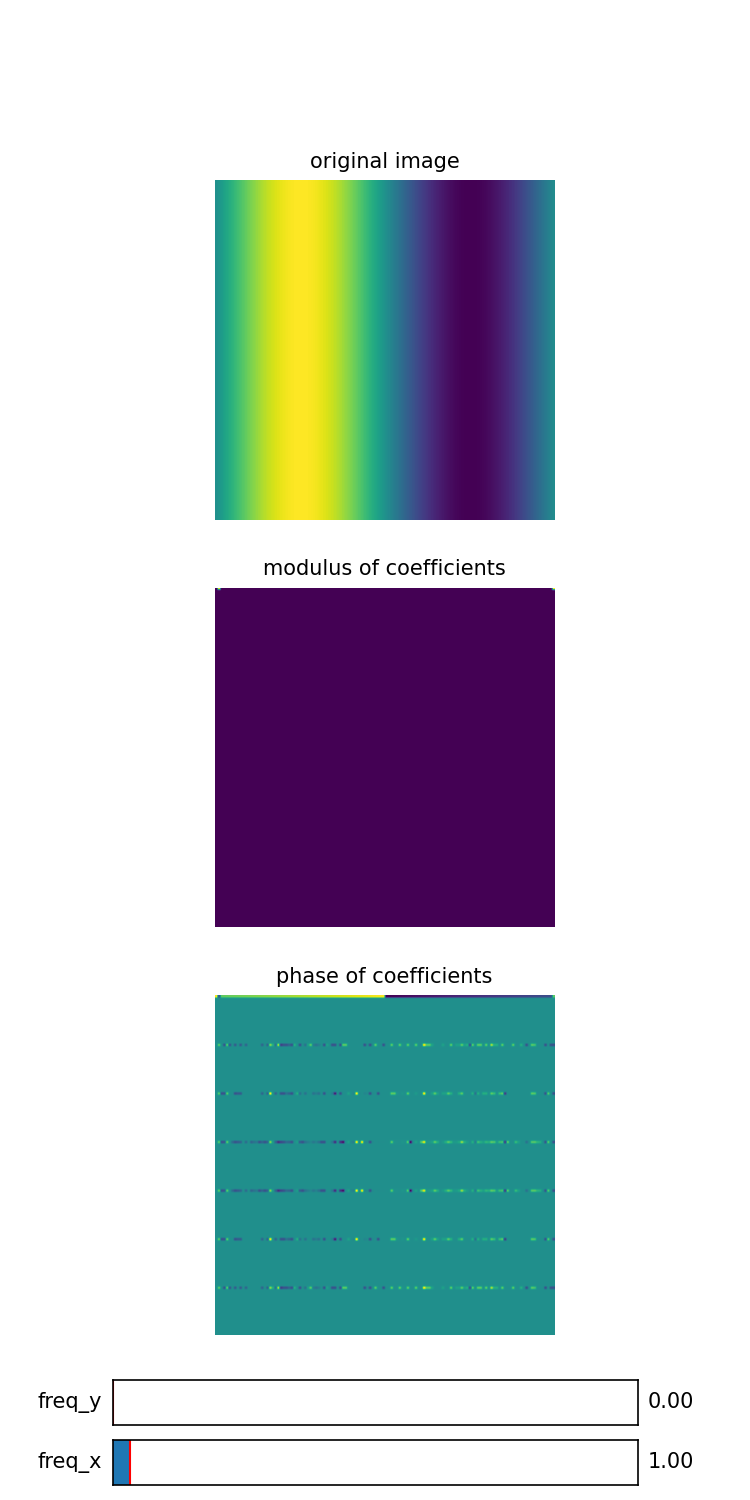

In [8]:
TWOPI = 2*np.pi
font_size = 10
freq_x = 1
freq_y = 0

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(5,10))
axes[0].set_title("original image", fontdict={"fontsize": font_size})
axes[1].set_title("modulus of coefficients", fontdict={"fontsize": font_size})
axes[2].set_title("phase of coefficients", fontdict={"fontsize": font_size})
for ax in axes: ax.axis('off')
x = np.arange(0.0, TWOPI, 0.05)
y = np.arange(0.0, TWOPI, 0.05)
spacex,spacey = np.meshgrid(x, x)
space = spacex*freq_x+spacey*freq_y

img = np.sin(space)
img_obj = []
img_obj.append(axes[0].imshow(img))
mod, angle = fourier_components(img)
img_obj.append(axes[1].imshow(mod))
img_obj.append(axes[2].imshow(angle))

locx = plt.axes([0.15, 0.01, 0.7, 0.03])
locy = plt.axes([0.15, 0.05, 0.7, 0.03])
x_slider = Slider(locx, 'freq_x', 0, 30, valinit=freq_x)
y_slider = Slider(locy, 'freq_y', 0, 30, valinit=freq_y)

def update_x(val):
    global freq_x
    freq_x = val
    space[:,:] = spacex*freq_x + spacey*freq_y
    img = np.sin(space)
    mod, angle = fourier_components(img)
    img_obj[0].set_data(img)
    img_obj[1].set_data(mod)
    img_obj[2].set_data(angle)
    fig.canvas.draw_idle()
    
    
def update_y(val):
    global freq_y
    freq_y = val
    space = spacex*freq_x + spacey*freq_y
    img = np.sin(space)
    mod, angle = fourier_components(img)
    img_obj[0].set_data(img)
    img_obj[1].set_data(mod)
    img_obj[2].set_data(angle)
    fig.canvas.draw_idle()

x_slider.on_changed(update_x)
y_slider.on_changed(update_y)

plt.show()

## Obliczanie korelacji

Twierdzenie o splocie:  
$x\star y = DFT^{-1}[DFT\{x\}*DFT\{y\}]$ 
Pozwala na szybkie obliczenie splotu przy pomocy dyskretynej transformaty Fouriera. Zakładając obraz i wzorzec o rozmiarach NxN i TxT złożności obliczeniowe wynoszą odpowiednio $O(N^2W^2)$ i $O(N^2)$

In [9]:
def corr(img, template):
    h, w = img.shape
    return (ifft2(fft2(img)*fft2(np.rot90(template,2),[h,w]))).astype(np.float64)

C = corr(galia, template_e)

/home/toot/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: ComplexWarning: Casting complex values to real discards the imaginary part
  This is separate from the ipykernel package so we can avoid doing imports until


Jak widać zastosowanie DTF powoduje znaczne przyspieszenie - na przykładowych danych aż 25-krotne

In [10]:
%%timeit
C = corr(galia, template_e)

/home/toot/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: ComplexWarning: Casting complex values to real discards the imaginary part
  This is separate from the ipykernel package so we can avoid doing imports until


134 ms ± 3.53 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [11]:
def slow_corr(img, template):
    C = np.zeros((h,w), dtype=np.float64)
    for i in range(h - 13):
        for j in range(w - 13):
            C[i+12,j+12] = np.sum(img[i:i+13,j:j+13]*template[:,:])
    return C
C_slow = slow_corr(galia, template_e)

In [12]:
%%timeit
slow_corr(galia, template_e)

3.65 s ± 260 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [13]:
np.allclose(C, C_slow)

True

In [14]:
# fig = plt.figure(figsize=(6,6))
# ax = plt.axes(projection='3d')
# X = np.linspace(-10, 10, w)
# Y = np.linspace(-10, 10, h)
# X, Y = np.meshgrid(X, Y)
# #R = 
# # Plot the surface.
# surf = ax.plot_surface(X, Y, C)
# #ax.set_zlim(-1.01, 15.01)
# plt.show()

<IPython.core.display.Javascript object>


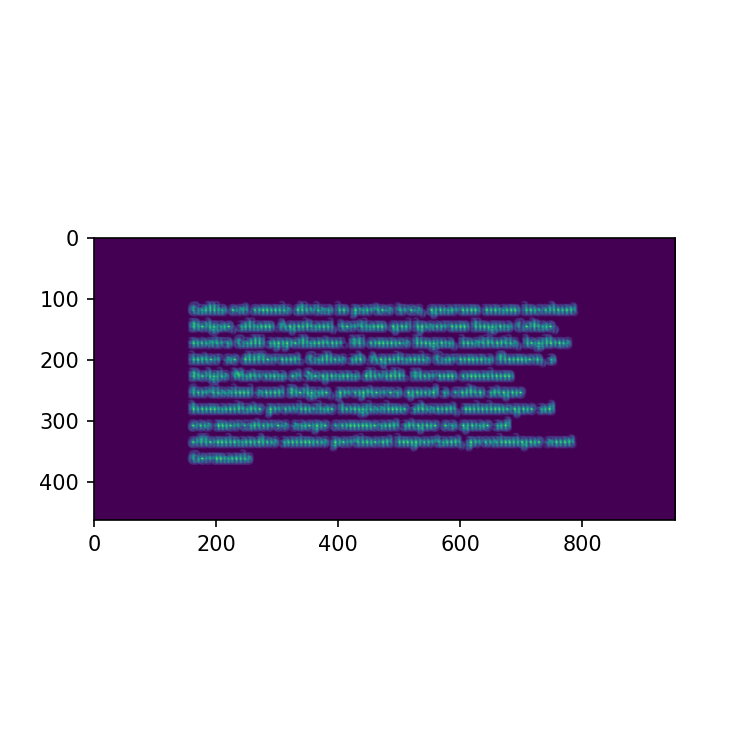

In [15]:
plt.figure(figsize=(5,5))
plt.imshow(C)
plt.show()

Dokonujemy normalizacji korelacji tak, aby jej wartości leżały w przedziale \[0, 1\] celem ułatwienia poszukiwania maximów.

In [16]:
def normalise(x):
    return (x - np.min(x))/np.max(x)

C = normalise(C)

Funkcja `count_max(C, template, threshold)` zlicza i zaznacza wszystkie lokalne maxima w macierzy `C`. Aby maximum zostało zliczone dla i,j jego wartość musi być większa niż `threshold` oraz nie może być w jego otoczeniu (zdefiniowanym przez `template`) wartości większych niż C\[i,j\].

In [17]:
def count_max(C, template=(13,13), threshold=0.9, rectangle=True):
    h, w = template
    y, x = h//2, w//2
    count = 0
    maxima = np.zeros(shape=C.shape)
    for i in range(C.shape[0]):
        for j in range(C.shape[1]):
           # print(i,j)
            if C[i,j] > threshold:
                r = np.sum(C[i-y:i+y+1,j-x:j+x+1]>=C[i,j])
              #  r = np.sum(C[i-h:i+1,j-w:j+1]>=C[i,j])
                if r==1:
                  #  print(C[i-x:i+x,j-y:j+y]>=C[i,j])
                    if rectangle:
                        maxima[i-h:i+1,j-w:j+1] = 255
                    else:
                        maxima[i,j] = 255
                    count+=1
    return count, maxima
#c,_ = count_max(maximum_filter(C, size=(13,13)))
#print(c)
c, maxima = count_max(C, threshold=0.9)
print(c)

43


<IPython.core.display.Javascript object>


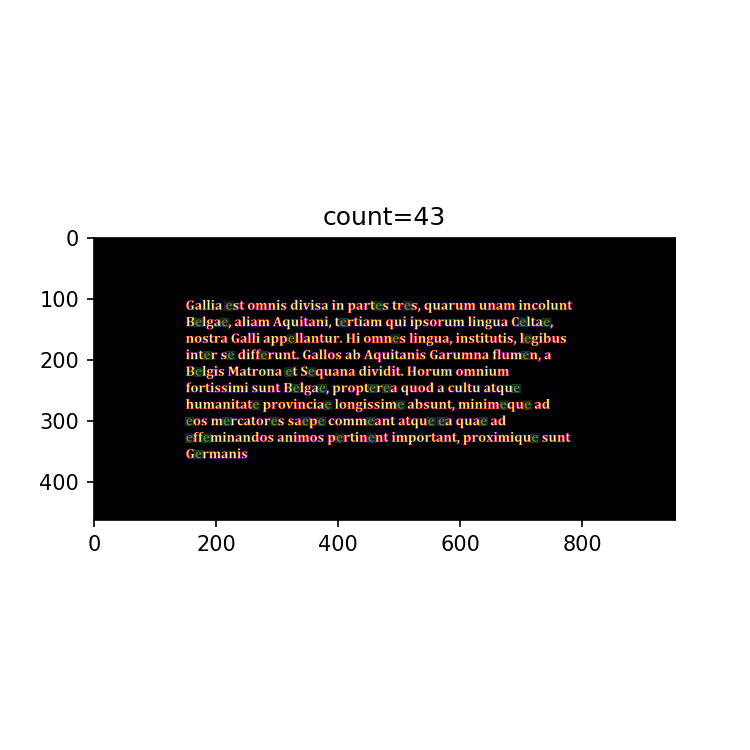

In [18]:
def show_max(background, maxima, alpha=0.6, cmap_back=None, cmap_max=None, title=""):
    plt.figure(figsize=(5,5))
    plt.imshow(background, cmap=cmap_back)
    mask = np.zeros(maxima.shape)
    mask[maxima != 0] = alpha
    plt.imshow(maxima, alpha=mask, cmap=cmap_max)
    plt.title(title)
    plt.show()
    
show_max(galia, maxima, cmap_back='inferno', cmap_max='Greens', title=f"count={c}")

## Ryby

In [19]:
school = np.array(Image.open("school.jpg")).astype(np.float64)
template_fish =  np.array(Image.open("fish1.png")).astype(np.float64)
h, w, _ = school.shape

In [20]:
C = [corr(img, temp).swapaxes(0,1) for img,temp in zip(school.swapaxes(0,2),template_fish.swapaxes(0,2))]
C = np.mean(C, axis=0)
C = normalise(C)

/home/toot/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: ComplexWarning: Casting complex values to real discards the imaginary part
  This is separate from the ipykernel package so we can avoid doing imports until


In [21]:
# school = np.array(Image.open("school.jpg").convert("YCbCr")).astype(np.float64)[:,:,0]
# template_fish =  np.array(Image.open("fish1.png").convert("YCbCr")).astype(np.float64)[:,:,0]
# h, w = school.shape
# C = corr(school, template_fish)
# C = normalise(C)

<IPython.core.display.Javascript object>


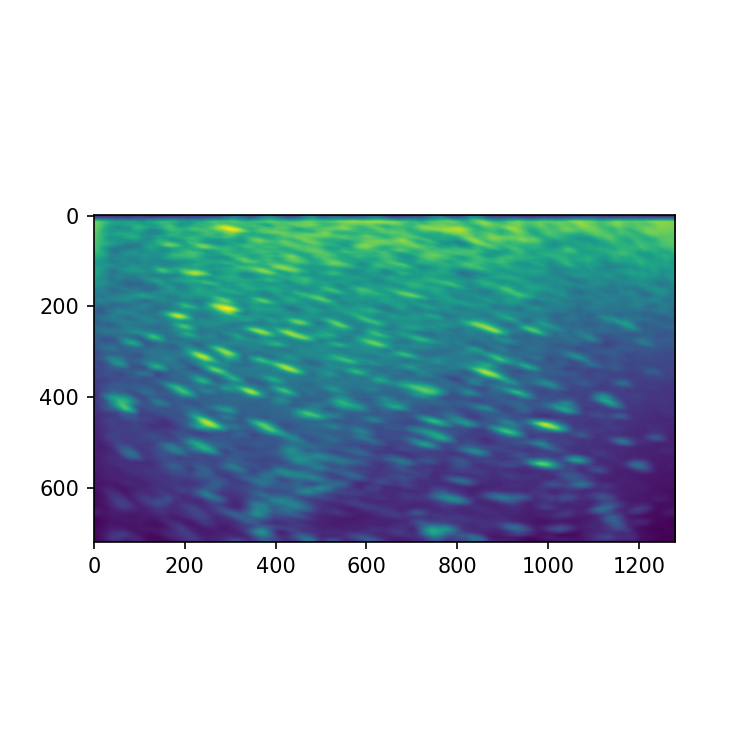

In [22]:
plt.figure(figsize=(5,5))
plt.imshow(C)
plt.show()

<IPython.core.display.Javascript object>


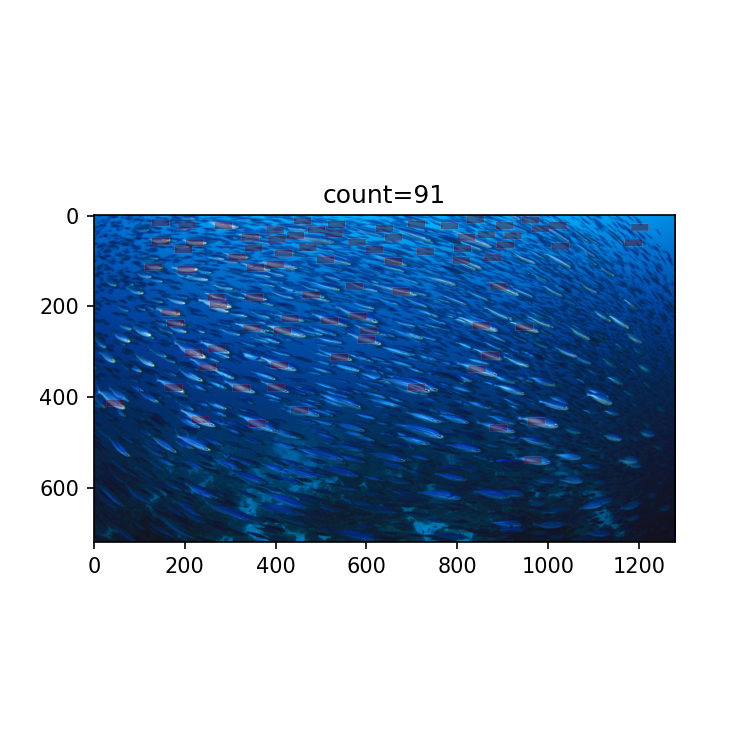

In [23]:
def show_example(C, threshold):
    c, maxima = count_max(C, template=template_fish.shape[:2],threshold=threshold)
    show_max(school.astype(np.uint8), maxima, alpha=0.4, cmap_max="Reds", title=f"count={c}")
    
show_example(C, 0.6)

<IPython.core.display.Javascript object>


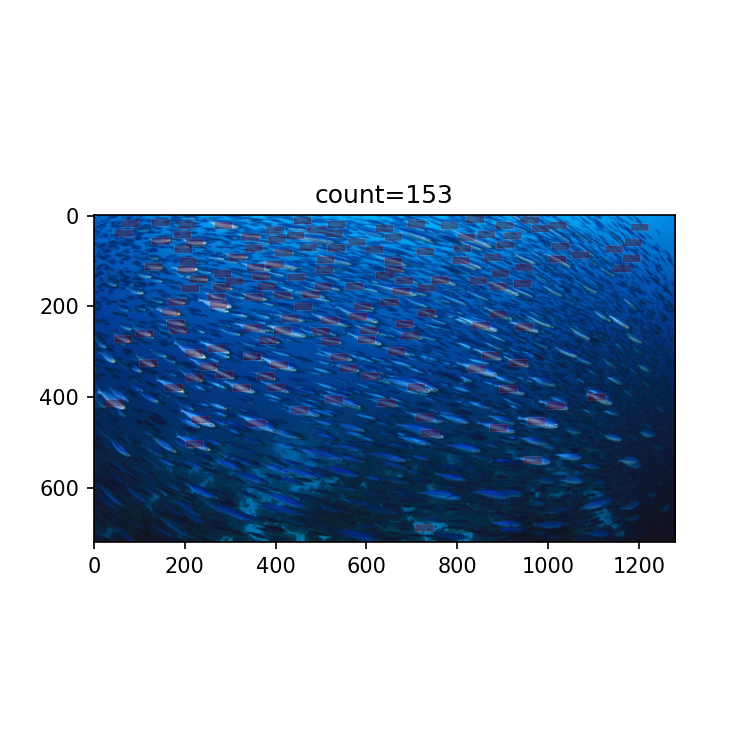

In [24]:
show_example(C, 0.5)

<IPython.core.display.Javascript object>


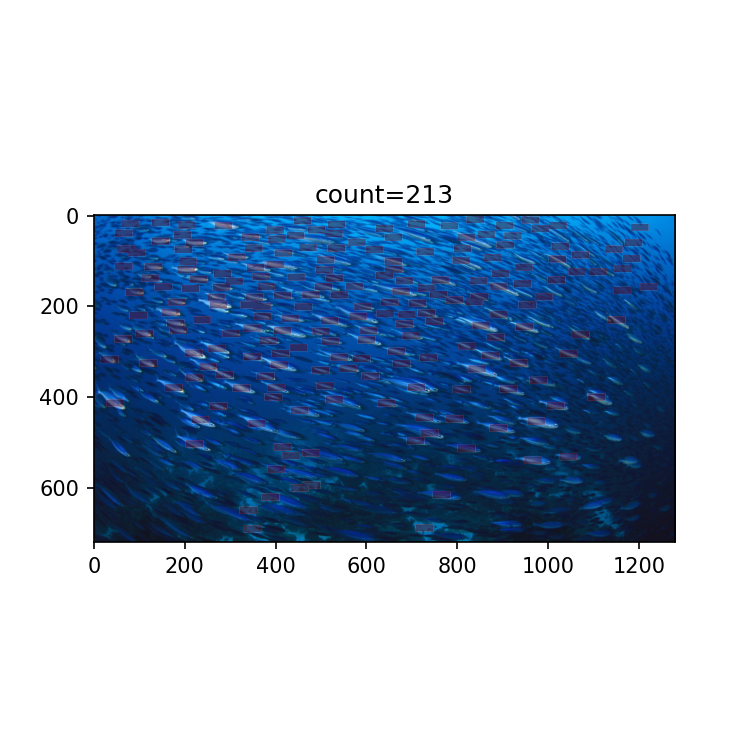

In [25]:
show_example(C, 0.4)

Zliczenie ryb ze zdjęcia przedstawionym sposobem okazuje się zadaniem skrajnie trudnym. Dla dużych wartośći progu sporo ryb zostaje pominiętych, z kolei dla małych zliczone zostają duże ilości niewyraźnych ryb z tła, które nie powinny być wykryte przez wzorzec.  
Problemy:
- różne kąty nachylenia ryb
- zmienne oświetlenie
- zmienna odległość od kamery, a co za tym idzie wielkość na zdjęciu

# OCR

In [26]:
from PIL import ImageFont
from PIL import ImageDraw 
import string

In [278]:
original_text = """szerszen wpada do pokoju
dowiedz sie, ze szerszenie widza w podczerwieni
przesylacie sobie piosenki"""

In [28]:
string.ascii_lowercase

'abcdefghijklmnopqrstuvwxyz'

In [29]:
def norm_corr(template, img=None, img_fft=None):
    assert not (img is None and img_fft is None)
    if img is not None:
        h, w = img.shape
    else:
        h, w = img_fft.shape
    norm = np.sum(template**2)
    if img_fft is None:
        img_fft = fft2(img)
    return (ifft2(img_fft*fft2(np.rot90(template,2),[h,w]))).astype(np.float64) / norm

In [302]:
def prepare_templates(font, angle=0,  margin=5, use_interpunction=False):
    templates = []
    n = max(max(font.getsize('W')), max(font.getsize('Q')))
    characters = string.ascii_lowercase
    if use_interpunction:
        characters += ",.!?"
    for letter in characters:
        letter_img = Image.fromarray(np.zeros((n+margin,n+margin)))
        draw = ImageDraw.Draw(letter_img)
        draw.text((margin, margin), letter, font=font, fill='#fff')
        letter_img = letter_img.rotate(angle, expand=True)
        template = np.array(letter_img)
        top, bot, left, right = 0, n, 0, n

        template = template[top:bot, left:right]
        templates.append((template, letter))
    return templates

font = ImageFont.truetype("/usr/share/fonts/truetype/freefont/FreeSerif.ttf", size=60)
templates = prepare_templates(font)

<IPython.core.display.Javascript object>


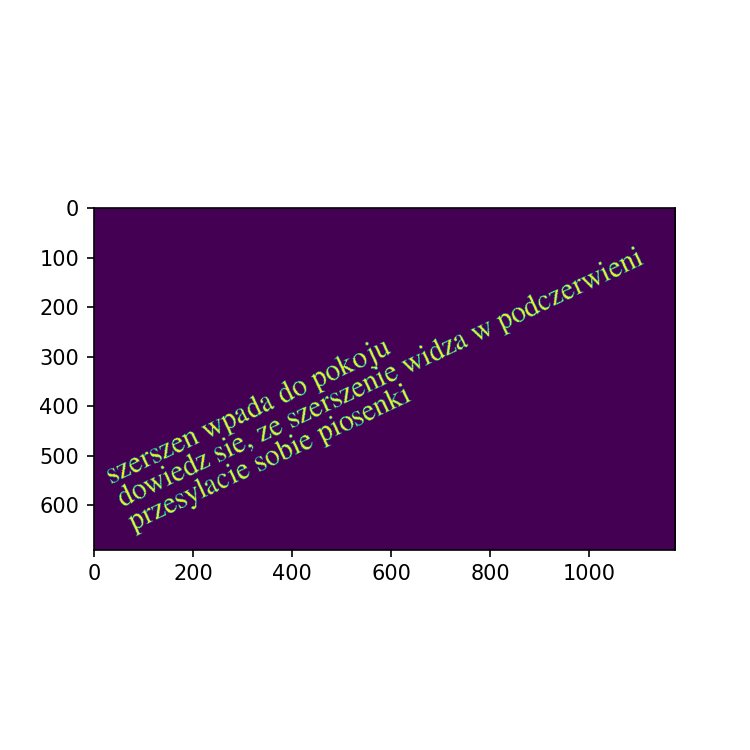

In [280]:
def make_image(text, angle, font, img_shape=(200,1200), text_start=(10,10)):
    img = Image.fromarray(np.zeros(img_shape))
    draw = ImageDraw.Draw(img)
    draw.text(text_start, original_text, font=font, fill='#fff')
    img = img.rotate(angle, expand=True)
    return np.array(img)


img = make_image(text, 25, font)
plt.figure(figsize=(5,5))
plt.imshow(img)
plt.show()

In [32]:
from tqdm import tqdm

In [239]:
def determine_angle(img, font, step=5):
    best_angle = 0
    best_corr = 0
    n = max(max(font.getsize('W')), max(font.getsize('Q')))
    templates = []
    base_template = Image.fromarray(np.zeros((n,n)))
    draw = ImageDraw.Draw(base_template)
    draw.text((0, 0), 'a', font=font, fill='#fff')
    img_fft = fft2(img)
    
    for angle in tqdm(range(-180, 181, step),position=0):
        C = norm_corr(np.array(base_template.rotate(angle)), img_fft=img_fft)
        if np.max(C) > best_corr:
          # print(np.max(C), angle)
            best_corr = np.max(C)
            best_angle = angle
    return best_angle
    
angle = determine_angle(img, font)
print(angle)

  0%|          | 0/73 [00:00<?, ?it/s]/home/toot/.local/lib/python3.6/site-packages/ipykernel_launcher.py:10: ComplexWarning: Casting complex values to real discards the imaginary part
  # Remove the CWD from sys.path while we load stuff.
100%|██████████| 73/73 [00:05<00:00, 12.72it/s]

20


  0%|          | 0/73 [00:00<?, ?it/s]/home/toot/.local/lib/python3.6/site-packages/ipykernel_launcher.py:10: ComplexWarning: Casting complex values to real discards the imaginary part
  # Remove the CWD from sys.path while we load stuff.
100%|██████████| 73/73 [00:07<00:00,  9.66it/s]


<IPython.core.display.Javascript object>


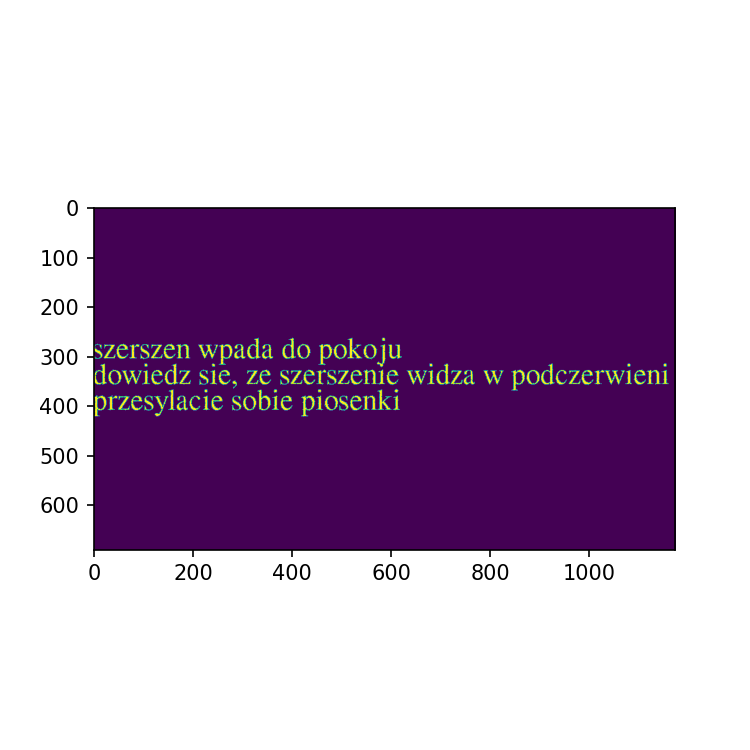

In [276]:
def unrotate(img, font):
    angle = determine_angle(img, font)
    img = np.array(Image.fromarray(img).rotate(-angle))
    return img
img = derotate(img, font)
plt.figure(figsize=(5,5))
plt.imshow(img)
plt.show()

In [265]:
templates = prepare_templates(font)

<IPython.core.display.Javascript object>


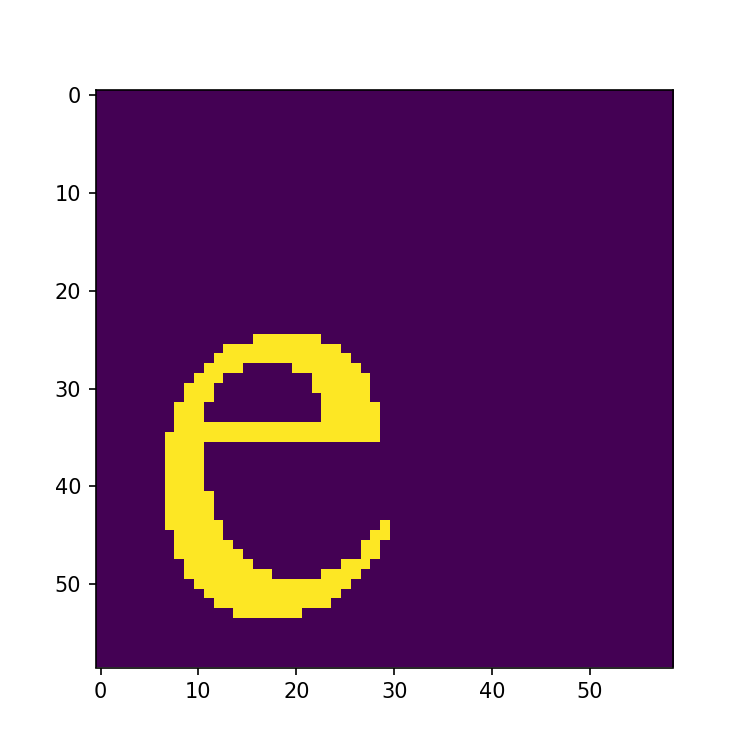

In [266]:
plt.figure(figsize=(5,5))
plt.imshow(templates[4][0])
plt.show()

In [315]:
def ocr(img, templates, space_size=25, threshold=0.95):
    text_array = np.zeros(img.shape, dtype=np.character)
    shape = [i for i in img.shape]
    C_archive = np.zeros([len(templates)] + shape, dtype=np.float32)
    img_fft = fft2(img)
    for i, (template, letter) in enumerate(templates):
        C = norm_corr(template, img_fft=img_fft)
        C_archive[i, :, :] = C[:, :]
        assert np.max(C) <= 1. + 1e-3, f"{letter} {np.max(C)}"
        c, maxima = count_max(C, rectangle=False, threshold=threshold)
        maxima_idx = maxima == 255
        overrited_idx = np.logical_and(text_array != b'', maxima)
        if np.any(overrited_idx):
            res = np.all(C_archive[:i, :, :] < C_archive[i, :, :], axis=0)
            maxima_idx[overrited_idx] = np.logical_and(overrited_idx, res)[overrited_idx]
            print(letter, text_array[maxima_idx])
        text_array[maxima_idx] = letter
        
    text = []
    for i in range(text_array.shape[0]):
        last_letter = -1;
        for j in range(text_array.shape[1]):
            if text_array[i,j] != b'':
                if last_letter == -1:
                    last_letter = j
                else:
                    if j - last_letter > space_size:
                        text.append(" ")
                    last_letter = j

                text.append(text_array[i,j].decode('ascii'))
        if last_letter != -1:
            text.append("\n")

    return "".join(text)

In [271]:
print(ocr(img, templates))

/home/toot/.local/lib/python3.6/site-packages/ipykernel_launcher.py:10: ComplexWarning: Casting complex values to real discards the imaginary part
  # Remove the CWD from sys.path while we load stuff.


e [b'c' b'' b'c' b'' b'c' b'c' b'' b'' b'' b'' b'' b'c' b'' b'']
l [b'' b'' b'' b'' b'' b'' b'' b'']
szerszen w pada dlo pokoju
l l
i dlow iedzsie ze szerszenie w idza w podczerw ien
l
przesylacie sobie piosenki
l l



In [363]:
def test_ocr(text, fontsize=40, space_size=25, font_type="FreeSerif", threshold=0.98):
    font = ImageFont.truetype(f"/usr/share/fonts/truetype/freefont/{font_type}.ttf", size=fontsize)
    img = make_image(text, 0, font)
    templates = prepare_templates(font)
    result = ocr(img, templates, space_size=space_size, threshold=threshold)
    print(levenshtein(text, result), "\n" + result)
    count = {l: 0 for l in text}
    for l in result: count[l] += 1
    for l, c in count.items(): print(f"l={repr(l)} | {c}")
test_ocr(original_text)

/home/toot/.local/lib/python3.6/site-packages/ipykernel_launcher.py:10: ComplexWarning: Casting complex values to real discards the imaginary part
  # Remove the CWD from sys.path while we load stuff.


8 
szerszen w pada do polkoju
dow iedz sie ze szerszenie w idza w podczerw ieni
przesylacie sobie piosenlki

l='s' | 8
l='z' | 9
l='e' | 14
l='r' | 4
l='n' | 4
l=' ' | 15
l='w' | 5
l='p' | 5
l='a' | 4
l='d' | 6
l='o' | 7
l='k' | 2
l='j' | 1
l='u' | 1
l='\n' | 3
l='i' | 10
l=',' | 0
l='c' | 2
l='y' | 1
l='l' | 3
l='b' | 1


In [356]:
font = ImageFont.truetype("/usr/share/fonts/truetype/freefont/FreeSerif.ttf", size=60)
img = make_image(original_text, 0, font)
#img = unrotate(img, font)
templates = prepare_templates(font)
result = ocr(img, templates, space_size=40, threshold=0.98)
print(levenshtein(original_text, result), "\n" + result)

/home/toot/.local/lib/python3.6/site-packages/ipykernel_launcher.py:10: ComplexWarning: Casting complex values to real discards the imaginary part
  # Remove the CWD from sys.path while we load stuff.


l [b'' b'' b'' b'' b'' b'']
19 
szerszen w pada do pokoju
l l
i dow iedzsie ze szerszenie w idza w podczerw ien
l
przesylacie sobie piosenki
l l



In [347]:
font = ImageFont.truetype("/usr/share/fonts/truetype/freefont/FreeMono.ttf", size=40)
img = make_image(original_text, 0, font)
#img = unrotate(img, font)
templates = prepare_templates(font, use_interpunction=True)
result = ocr(img, templates, space_size=30, threshold=0.99)
print(levenshtein(original_text, result), "\n" + result)

/home/toot/.local/lib/python3.6/site-packages/ipykernel_launcher.py:10: ComplexWarning: Casting complex values to real discards the imaginary part
  # Remove the CWD from sys.path while we load stuff.


1 
szerszen wpada do pokoju
dowiedz sie, ze szerszenie widza w podczerwieni
przesylacie sobie piosenki



<IPython.core.display.Javascript object>


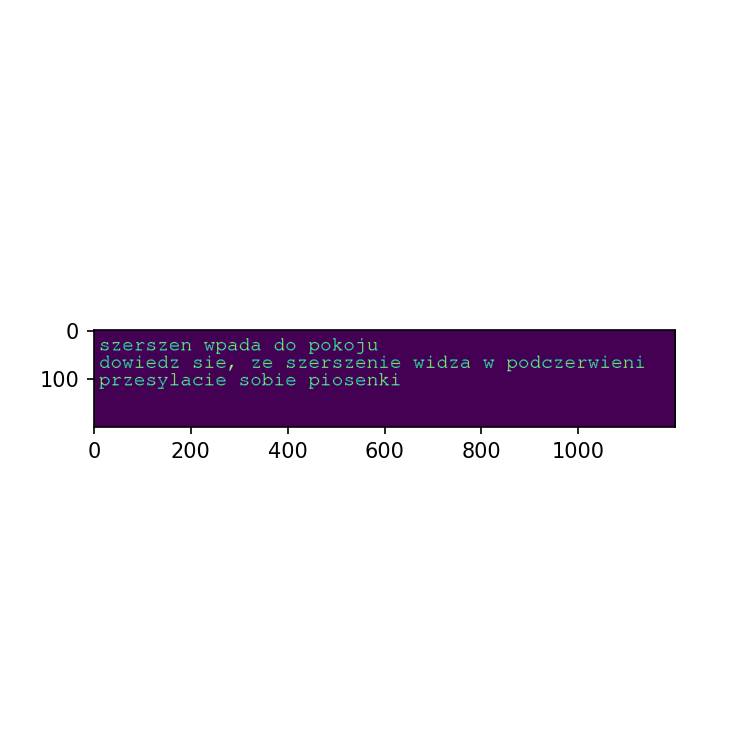

In [313]:
plt.figure(figsize=(5,5))
plt.imshow(img)
plt.show()

In [348]:
font = ImageFont.truetype("/usr/share/fonts/truetype/freefont/FreeSans.ttf", size=40)
img = make_image(original_text, 0, font)
#img = unrotate(img, font)
templates = prepare_templates(font)
result = ocr(img, templates, space_size=30, threshold=0.9999)
print(levenshtein(original_text, result), "\n" + result)

/home/toot/.local/lib/python3.6/site-packages/ipykernel_launcher.py:10: ComplexWarning: Casting complex values to real discards the imaginary part
  # Remove the CWD from sys.path while we load stuff.


l [b'']
20 
szerszen wpada do pojikojiu
dowjiedzsjie ze szerszenjie wjidza w podczerwjienji
przesyjilacjie sobjie pjiosenjikji



<IPython.core.display.Javascript object>


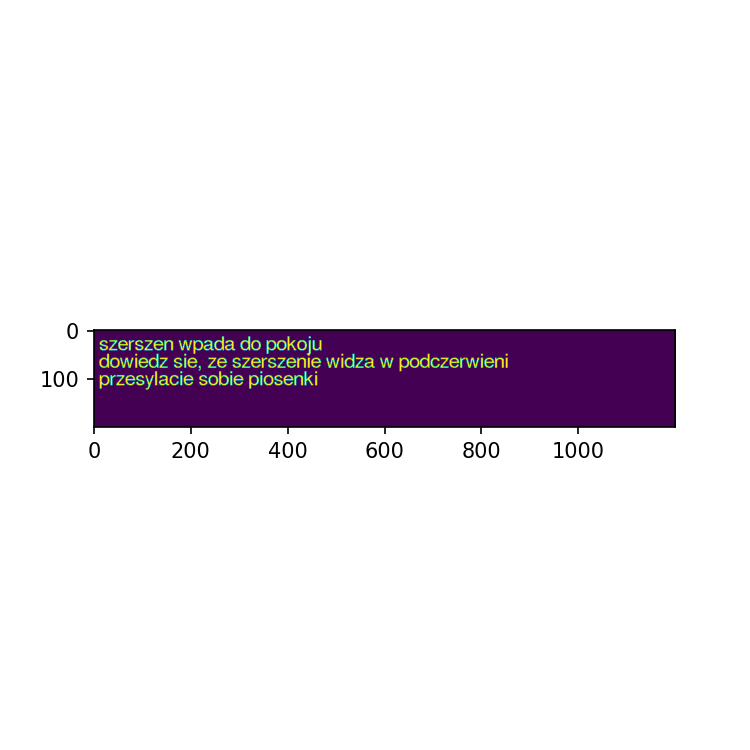

In [320]:
plt.figure(figsize=(5,5))
plt.imshow(img)
plt.show()

In [340]:
from textdistance.algorithms.edit_based import levenshtein